In [20]:
# Import libraries
from joblib import dump
import scikitplot as skplt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [21]:

# Load the dataset
df_official = pd.read_csv('cleaned_data_KSI.csv')

In [22]:

# Display dataset information
print(df_official.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17522 entries, 0 to 17521
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LATITUDE       17522 non-null  float64
 1   LONGITUDE      17522 non-null  float64
 2   ACCLOC         12514 non-null  object 
 3   VISIBILITY     17522 non-null  object 
 4   LIGHT          17522 non-null  object 
 5   RDSFCOND       17522 non-null  object 
 6   ACCLASS        17522 non-null  object 
 7   IMPACTYPE      17522 non-null  object 
 8   INVTYPE        17522 non-null  object 
 9   INVAGE         17522 non-null  object 
 10  INJURY         16001 non-null  object 
 11  DRIVCOND       8935 non-null   object 
 12  PEDESTRIAN     17522 non-null  int64  
 13  CYCLIST        17522 non-null  int64  
 14  AUTOMOBILE     17522 non-null  int64  
 15  MOTORCYCLE     17522 non-null  int64  
 16  TRUCK          17522 non-null  int64  
 17  TRSN_CITY_VEH  17522 non-null  int64  
 18  EMERG_

In [23]:

# Display dataset statistics
print(df_official.describe().T)

                 count       mean        std        min        25%        50%  \
LATITUDE       17522.0  43.710888   0.055820  43.589678  43.662398  43.703255   
LONGITUDE      17522.0 -79.395151   0.104214 -79.638390 -79.468326 -79.396390   
PEDESTRIAN     17522.0   0.410798   0.491993   0.000000   0.000000   0.000000   
CYCLIST        17522.0   0.108264   0.310722   0.000000   0.000000   0.000000   
AUTOMOBILE     17522.0   0.908972   0.287658   0.000000   1.000000   1.000000   
MOTORCYCLE     17522.0   0.087205   0.282143   0.000000   0.000000   0.000000   
TRUCK          17522.0   0.061123   0.239563   0.000000   0.000000   0.000000   
TRSN_CITY_VEH  17522.0   0.062493   0.242055   0.000000   0.000000   0.000000   
EMERG_VEH      17522.0   0.002454   0.049479   0.000000   0.000000   0.000000   
SPEEDING       17522.0   0.138226   0.345147   0.000000   0.000000   0.000000   
AG_DRIV        17522.0   0.520831   0.499580   0.000000   0.000000   1.000000   
REDLIGHT       17522.0   0.0

In [24]:

# Separate features and target variable
x_group3 = df_official.drop(columns=['ACCLASS'], axis=1)
y_group3 = df_official['ACCLASS']

In [25]:

# Split the dataset into training and testing sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in sss.split(x_group3, y_group3):
    x_train, x_test = x_group3.loc[train_index], x_group3.loc[test_index]
    y_train, y_test = y_group3.loc[train_index], y_group3.loc[test_index]

In [26]:

# Print class distribution before using SMOTE
print("Before using SMOTE")
print(y_train.value_counts())

Before using SMOTE
Non-Fatal Injury    10564
Fatal                1701
Name: ACCLASS, dtype: int64


In [27]:

# Preprocessing pipelines for numerical and categorical features
numerical_cols = x_train.select_dtypes(include=np.number).columns
cat_cols = x_train.select_dtypes(include='object').columns

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, cat_cols)
])

svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
])

# Transform training data and apply SMOTE
x_train_prepared = svm_pipeline.fit_transform(x_train)
x_train_prepared, y_train = SMOTE(
    random_state=42).fit_resample(x_train_prepared, y_train)

# Print class distribution after using SMOTE
print("After using SMOTE")
print(y_train.value_counts())

After using SMOTE
Fatal               10564
Non-Fatal Injury    10564
Name: ACCLASS, dtype: int64


In [28]:

# Train SVM model
svm_model = SVC(random_state=42, probability=True)
svm_model.fit(x_train_prepared, y_train)

# Evaluate the model
crossvalscore = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(svm_model, x_train_prepared,
                         y_train, cv=crossvalscore, scoring='accuracy')
print("Cross validation scores for 10 folds: ", scores)
print("Mean cross validation score: ", scores.mean())

Cross validation scores for 10 folds:  [0.89351633 0.8902035  0.89162328 0.89919546 0.88405111 0.89966872
 0.90250828 0.90014198 0.9000947  0.90246212]
Mean cross validation score:  0.8963465478853848


In [29]:

# Make predictions on training data
y_pred_train = svm_model.predict(x_train_prepared)
print("Accuracy score on training data: ",
      accuracy_score(y_train, y_pred_train))

Accuracy score on training data:  0.9129591063990913


In [30]:

# Make predictions on testing data
x_test_transformed = svm_pipeline.transform(x_test)
y_pred_test = svm_model.predict(x_test_transformed)
print("Accuracy score on testing data: ", accuracy_score(y_test, y_pred_test))

Accuracy score on testing data:  0.848773064485448


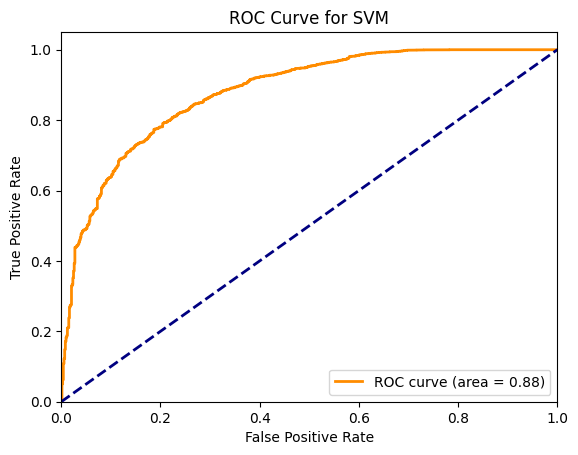

In [32]:

y_probas = svm_model.predict_proba(x_test_transformed)
fpr, tpr, _ = roc_curve(y_test, y_probas[:, 1], pos_label='Non-Fatal Injury')
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.legend(loc="lower right")
plt.show()

In [33]:

# Print classification report and confusion matrix
report = classification_report(y_test, y_pred_test)
print("Classification report of SVM model before tuning")
print(report)

Classification report of SVM model before tuning
                  precision    recall  f1-score   support

           Fatal       0.47      0.69      0.56       729
Non-Fatal Injury       0.95      0.88      0.91      4528

        accuracy                           0.85      5257
       macro avg       0.71      0.78      0.73      5257
    weighted avg       0.88      0.85      0.86      5257



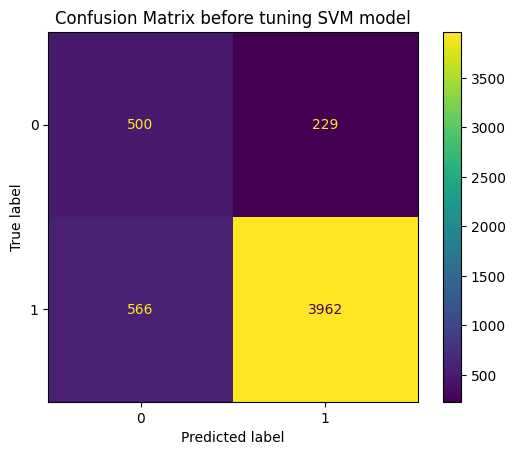

In [34]:

cfs_matrix = confusion_matrix(y_test, y_pred_test)
display = ConfusionMatrixDisplay(cfs_matrix)
display.plot()
plt.title("Confusion Matrix before tuning SVM model")
plt.show()

In [35]:
# Save the trained model and pipeline
dump(svm_model, '../deployment/svm_model.pkl')
dump(svm_pipeline, '../deployment/svm_pipeline.pkl')

['./deployment/svm_pipeline.pkl']